In [34]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import math
import torch.nn.functional as F

import medmnist
from medmnist import INFO

In [35]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [36]:
import os
from torchvision.utils import save_image

sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

# We first work on a 2D dataset with size 28x28

In [37]:
# data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 20000
BATCH_SIZE = 128
lr = 1e-5
image_size = 28 * 28
latent_dim = 256

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [38]:
# preprocessing
data_transform = transforms.Compose([
    
    transforms.ToTensor(),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)
z_dim = 32

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [39]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\HP\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\HP\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning

In [40]:
# visualization

train_dataset.montage(length=1)

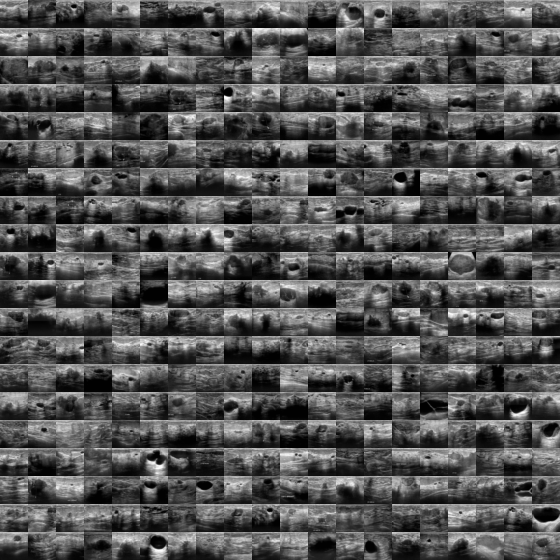

In [41]:
# montage

train_dataset.montage(length=20)

# Then, we define a basic VAE.

In [42]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

In [43]:
class UnFlatten(nn.Module):
    def forward(self, x):
        # Adjusted for 7x7 spatial dimensions, 128 channels
        return x.view(x.size(0), 128, 7, 7)

In [44]:
class Sampling(nn.Module):
    def forward(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

In [45]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),   # 28 → 14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14 → 7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 7 → 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),# 4 → 2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),# 2 → 1
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = self.encoder(x)       # (B, 512, 1, 1)
        x = self.flatten(x)       # (B, 512)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        z = self.sampling(mu, log_var)
        return z, mu, log_var

In [46]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 1 * 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 1 → 2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 2 → 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 4 → 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # 8 → 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),     # 16 → 32
            nn.Sigmoid()  # Use for [0, 1] output
        )

    def forward(self, z):
        x = self.fc(z)               # (B, 512)
        x = x.view(-1, 512, 1, 1)    # (B, 512, 1, 1)
        x = self.decoder(x)         # (B, 1, 32, 32)
        return x[:, :, :28, :28]    # Crop to (B, 1, 28, 28)

In [47]:
class VAE(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, log_var, z = self.encoder(x)
        recon = self.decoder(z)
        return recon, mu, log_var

    def calculate_loss(self, x, recon, mu, log_var):
        reconst_loss_per_element = F.binary_cross_entropy(reconstruction, x, reduction='none')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
        kl_loss = torch.mean(kl_loss)
        total = recon_loss + kl_loss
        return total, recon_loss, kl_loss

# Next, we can start to train and evaluate!

In [48]:
# Device configuration
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae = VAE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vae.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
image_channels = 1

for epoch in range(NUM_EPOCHS):
    # Initialize accumulators for losses for the current epoch
    total_epoch_loss = 0.0
    total_epoch_reconst_loss = 0.0
    total_epoch_kl_loss = 0.0
    num_batches = 0

    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)

        # Forward pass: model returns reconstructed output, mu, log_var
        x_reconst, mu, log_var = model(x)

        # --- Compute Reconstruction Loss (matching Keras) ---
        reconst_loss_per_element = F.binary_cross_entropy(x_reconst, x, reduction='none')
        reconst_loss_per_sample_channel = torch.sum(reconst_loss_per_element, dim=(2, 3))
        reconst_loss = torch.mean(reconst_loss_per_sample_channel)

        # --- Compute KL Divergence (matching Keras) ---
        kl_div_per_element = - 0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
        kl_div_per_sample = torch.sum(kl_div_per_element, dim=1)
        kl_div = torch.mean(kl_div_per_sample)

        # --- Total Loss (matches Keras) ---
        loss = reconst_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate losses for epoch-wise average printing
        total_epoch_loss += loss.item()
        total_epoch_reconst_loss += reconst_loss.item()
        total_epoch_kl_loss += kl_div.item()
        num_batches += 1

    # Calculate average losses for the epoch
    avg_total_loss = total_epoch_loss / num_batches
    avg_reconst_loss = total_epoch_reconst_loss / num_batches
    avg_kl_loss = total_epoch_kl_loss / num_batches

    # Print epoch-wise summary
    print ("Epoch[{}/{}], Avg Total Loss: {:.4f}, Avg Reconst Loss: {:.4f}, Avg KL Div: {:.4f}"
           .format(epoch+1, NUM_EPOCHS, avg_total_loss, avg_reconst_loss, avg_kl_loss))

    # with torch.no_grad():
    #     num_samples_to_save = 10
    #     z_fixed = torch.randn(num_samples_to_save, model.latent_dim).to(device)
    #     out_sampled = model.decoder(z_fixed).view(-1, image_channels, 28, 28)
    #     save_image(out_sampled, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)), nrow=10)

    #     num_reconstruct_to_save = 10
    #     x_for_saving = next(iter(train_loader))[0][:num_reconstruct_to_save].to(device)

    #     out_reconst_for_save, _, _ = model(x_for_saving)

    #     x_concat_to_save = torch.cat([
    #         x_for_saving.view(-1, image_channels, 28, 28),
    #         out_reconst_for_save.view(-1, image_channels, 28, 28)
    #     ], dim=3)
    #     save_image(x_concat_to_save, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)), nrow=5)

Epoch[1/20000], Avg Total Loss: 821.6278, Avg Reconst Loss: 648.6771, Avg KL Div: 172.9507
Epoch[2/20000], Avg Total Loss: 808.3276, Avg Reconst Loss: 636.9655, Avg KL Div: 171.3620
Epoch[3/20000], Avg Total Loss: 797.8703, Avg Reconst Loss: 628.3022, Avg KL Div: 169.5680
Epoch[4/20000], Avg Total Loss: 787.6589, Avg Reconst Loss: 620.0159, Avg KL Div: 167.6430
Epoch[5/20000], Avg Total Loss: 777.2837, Avg Reconst Loss: 612.0168, Avg KL Div: 165.2669
Epoch[6/20000], Avg Total Loss: 768.9953, Avg Reconst Loss: 604.5980, Avg KL Div: 164.3973
Epoch[7/20000], Avg Total Loss: 760.9404, Avg Reconst Loss: 597.9395, Avg KL Div: 163.0009
Epoch[8/20000], Avg Total Loss: 751.9803, Avg Reconst Loss: 590.8638, Avg KL Div: 161.1166
Epoch[9/20000], Avg Total Loss: 744.3426, Avg Reconst Loss: 585.0193, Avg KL Div: 159.3233
Epoch[10/20000], Avg Total Loss: 737.4061, Avg Reconst Loss: 580.1248, Avg KL Div: 157.2813
Epoch[11/20000], Avg Total Loss: 730.3614, Avg Reconst Loss: 573.8867, Avg KL Div: 156.47

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow_tensor(img_tensor, title=None):
    """
    Displays a PyTorch image tensor.

    Args:
        img_tensor (torch.Tensor): The image tensor.
                                   Expected shape: (C, H, W) for single image
                                   or (N, C, H, W) for a batch.
                                   Assumes pixel values are in [0, 1] or can be normalized.
        title (str, optional): Title for the plot. Defaults to None.
    """
    # If it's a batch of images (4 dimensions: N, C, H, W), make a grid.
    if img_tensor.dim() == 4:
        # Determine nrow to make a somewhat square grid, or you can force it
        # For a full grid that's roughly square:
        num_images = img_tensor.shape[0]
        nrow = int(num_images**0.5) # Example: For 64 images, nrow will be 8
        if nrow == 0: nrow = 1 # Avoid division by zero for very small batches

        img_tensor = make_grid(img_tensor, nrow=nrow, normalize=True, scale_each=True)
        # normalize=True scales values to [0,1] for display, scale_each=True normalizes each image separately

    np_img = img_tensor.cpu().numpy()
    if np_img.ndim == 3 and np_img.shape[0] in [1, 3]: # Check for (C, H, W) format
        np_img = np.transpose(np_img, (1, 2, 0))
    if np_img.shape[-1] == 1: # For grayscale (H, W, 1) -> (H, W)
        np_img = np_img.squeeze(-1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# --- How to display a full batch in a grid ---

# Get a full batch from your test_loader (or train_loader)
# Ensure test_loader and device are defined from your setup
# (e.g., as in the MedMNIST data loading example)

# Example: Get the first full batch of original images
x_batch, _ = next(iter(test_loader))
x_batch = x_batch.to(device)

print("Displaying a Full Batch of Original Images in a Grid:")
imshow_tensor(x_batch, title="Full Batch of Original Images")

# You can do the same for reconstructed images or generated samples if you have them in a batch:

# Example: Get a full batch of reconstructed images (assuming your model returns N, C, H, W or N, C, D, H, W)
# This assumes your model's forward pass gives you the correct output format
with torch.no_grad():
    reconstructed_batch, _, _ = model(x_batch) # Pass the full batch
    # Ensure it's in (N, C, H, W) format for make_grid, adjust view if needed for 3D -> 2D slices
    if reconstructed_batch.dim() == 5: # If your model outputs 3D (N, C, D, H, W)
        # You would need to select a slice to make it 2D for imshow_tensor
        # For simplicity, let's take a middle slice for all images in the batch
        middle_slice_idx = reconstructed_batch.shape[2] // 2 # Middle slice in depth
        reconstructed_batch_2d = reconstructed_batch[:, :, middle_slice_idx, :, :]
        print("\nDisplaying a Full Batch of Reconstructed Slices (middle depth) in a Grid:")
        imshow_tensor(reconstructed_batch_2d, title="Full Batch of Reconstructed Slices")
    else: # It's already 4D (N, C, H, W)
        print("\nDisplaying a Full Batch of Reconstructed Images in a Grid:")
        imshow_tensor(reconstructed_batch, title="Full Batch of Reconstructed Images")

# Example: Generate a full batch of new samples
with torch.no_grad():
    num_samples_to_generate = BATCH_SIZE # Generate as many as your batch size
    z_full_batch = torch.randn(num_samples_to_generate, model.latent_dim).to(device)
    generated_batch = model.decoder(z_full_batch)
    # Adjust view based on whether your decoder outputs 2D or 3D images
    if generated_batch.dim() == 5: # If 3D (N, C, D, H, W)
        middle_slice_idx = generated_batch.shape[2] // 2
        generated_batch_2d = generated_batch[:, :, middle_slice_idx, :, :]
        print("\nDisplaying a Full Batch of Generated Slices (middle depth) in a Grid:")
        imshow_tensor(generated_batch_2d, title="Full Batch of Generated Slices")
    else: # If 2D (N, C, H, W)
        print("\nDisplaying a Full Batch of Generated Images in a Grid:")
        imshow_tensor(generated_batch, title="Full Batch of Generated Images")

In [ ]:
inference(1)